In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [21]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
def read_language_pairs(filepath, max_samples=10000):
    """Read language pairs from file with tab separation"""
    pairs = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if '\t' in line:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    source, target = parts[0], parts[1]
                    pairs.append((source.lower(), target.lower()))

    # Shuffle and limit sample size
    random.shuffle(pairs)
    return pairs[:max_samples]

In [24]:
def create_dictionary(sentences):
    """Create word-to-index dictionary from sentences"""
    word_dict = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}

    # Count all words
    word_counts = Counter()
    for sentence in sentences:
        words = sentence.split()
        word_counts.update(words)

    # Add words to dictionary
    for word in word_counts:
        if word not in word_dict:
            word_dict[word] = len(word_dict)

    return word_dict

In [25]:
def words_to_indices(sentence, word_dict):
    """Convert words in a sentence to indices using dictionary"""
    return [word_dict.get(word, word_dict['<unk>']) for word in sentence.split()]

In [26]:
def prepare_training_data(pairs, source_dict, target_dict):
    """Convert all sentence pairs to tensor format"""
    source_tensors = []
    target_tensors = []

    for source_sent, target_sent in pairs:
        # Convert source sentence
        source_indices = words_to_indices(source_sent, source_dict)
        source_tensor = torch.tensor(source_indices, dtype=torch.long)

        # Convert target sentence with start/end tokens
        target_indices = [target_dict['<start>']]
        target_indices.extend(words_to_indices(target_sent, target_dict))
        target_indices.append(target_dict['<end>'])
        target_tensor = torch.tensor(target_indices, dtype=torch.long)

        source_tensors.append(source_tensor)
        target_tensors.append(target_tensor)

    return source_tensors, target_tensors

In [27]:
def create_batch(source_list, target_list, source_pad_idx, target_pad_idx, batch_size=64):
    """Create a batch of padded sequences"""
    # Get batch indices
    indices = list(range(len(source_list)))
    random.shuffle(indices)
    batch_indices = indices[:batch_size]

    # Get sequences for this batch
    source_batch = [source_list[i] for i in batch_indices]
    target_batch = [target_list[i] for i in batch_indices]

    # Pad sequences
    padded_sources = pad_sequence(source_batch, batch_first=True, padding_value=source_pad_idx)
    padded_targets = pad_sequence(target_batch, batch_first=True, padding_value=target_pad_idx)

    return padded_sources.to(device), padded_targets.to(device)


In [28]:
class AttentionEncoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(AttentionEncoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, source):
        # source shape: [batch_size, seq_len]
        embedded = self.embedding(source)  # [batch_size, seq_len, embedding_dim]

        # Run through LSTM and keep all outputs
        outputs, (hidden, cell) = self.lstm(embedded)

        # Return full sequence of outputs plus final states
        return outputs, (hidden, cell)

In [29]:
class AdditiveBahdanauAttention(nn.Module):
    """Bahdanau attention mechanism (additive attention)"""
    def __init__(self, hidden_dim):
        super(AdditiveBahdanauAttention, self).__init__()
        # Energy calculation layers
        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: [1, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        # Reshape hidden for broadcasting
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Create a copy of hidden state for each source word
        hidden = decoder_hidden[-1].unsqueeze(1).repeat(1, src_len, 1)

        # Calculate energy scores
        energy = torch.tanh(self.w1(hidden) + self.w2(encoder_outputs))

        # Calculate attention weights
        attention = torch.sum(self.v * energy, dim=2)

        # Return normalized attention weights
        return F.softmax(attention, dim=1)


In [38]:
class DotProductLuongAttention(nn.Module):
    """Luong attention mechanism (multiplicative attention)"""
    def __init__(self, hidden_dim):
        super(DotProductLuongAttention, self).__init__()
        self.projection = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: [1, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        # Reshape hidden for matrix multiplication
        hidden = decoder_hidden[-1].unsqueeze(2)  # [batch_size, hidden_dim, 1]

        # Project encoder outputs
        projected_outputs = self.projection(encoder_outputs)

        # Calculate attention scores with batch matrix multiplication
        energy = torch.bmm(projected_outputs, hidden).squeeze(2)

        # Return normalized attention weights
        return F.softmax(energy, dim=1)

In [40]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, attention_type='bahdanau'):
        super(AttentionDecoder, self).__init__()
        self.attention_type = attention_type
        self.embedding = nn.Embedding(output_size, embedding_dim)

        # Create attention mechanism based on type
        if attention_type == 'bahdanau':
            self.attention = AdditiveBahdanauAttention(hidden_dim)
        elif attention_type == 'luong':
            self.attention = DotProductLuongAttention(hidden_dim)
        else:
            raise ValueError(f"Unknown attention type: {attention_type}")

        # Decoder LSTM - input is embedding + context
        self.lstm = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, batch_first=True)

        # Output projection
        self.output_layer = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, target, hidden, cell, encoder_outputs):
        # target shape: [batch_size]
        # hidden, cell: [1, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        # Embed input token
        embedded = self.embedding(target.unsqueeze(1))  # [batch_size, 1, embedding_dim]

        # Calculate attention weights
        attn_weights = self.attention(hidden, encoder_outputs)  # [batch_size, src_len]

        # Create context vector by applying attention weights to encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_dim]

        # Concatenate embedding and context
        lstm_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, embedding_dim + hidden_dim]

        # Pass through LSTM
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        # Concatenate LSTM output and context for prediction
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)

        # Project to vocabulary size
        prediction = self.output_layer(output)  # [batch_size, output_size]

        return prediction, hidden, cell, attn_weights


In [41]:
class AttentionTranslator(nn.Module):
    def __init__(self, encoder, decoder):
        super(AttentionTranslator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source: [batch_size, source_len]
        # target: [batch_size, target_len]

        batch_size = target.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_layer.out_features

        # Tensor to store decoder outputs and attention maps
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        attentions = torch.zeros(batch_size, target_len, source.shape[1]).to(device)

        # Encode the source sequence
        encoder_outputs, (hidden, cell) = self.encoder(source)

        # First input to the decoder is the <start> token
        input = target[:, 0]

        # Decode one step at a time
        for t in range(1, target_len):
            # Pass through decoder with attention
            output, hidden, cell, attn_weights = self.decoder(input, hidden, cell, encoder_outputs)

            # Store prediction and attention weights
            outputs[:, t] = output
            attentions[:, t] = attn_weights

            # Teacher forcing decision
            teacher_force = random.random() < teacher_forcing_ratio

            # Get next input (either from ground truth or prediction)
            input = target[:, t] if teacher_force else output.argmax(1)

        return outputs, attentions


In [42]:
def train_attention_translator(model, train_source, train_target, val_source=None, val_target=None,
                              epochs=5, batch_size=64, teacher_forcing=0.5):
    """Train the translator model with attention"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=target_dict['<pad>'])

    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0

        # Train on batches
        for i in range(0, len(train_source), batch_size):
            # Create batch
            if i + batch_size <= len(train_source):
                source_batch = train_source[i:i+batch_size]
                target_batch = target_target[i:i+batch_size]

                src, tgt = create_batch(source_batch, target_batch,
                                       source_dict['<pad>'], target_dict['<pad>'],
                                       batch_size=len(source_batch))

                # Forward pass
                output, _ = model(src, tgt, teacher_forcing_ratio=teacher_forcing)

                # Calculate loss (ignoring padding and first token which is <start>)
                output_flat = output[:, 1:].reshape(-1, output.shape[-1])
                target_flat = tgt[:, 1:].reshape(-1)
                loss = criterion(output_flat, target_flat)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update weights
                optimizer.step()

                epoch_loss += loss.item()
                batch_count += 1

        # Validation
        if val_source and val_target:
            model.eval()
            with torch.no_grad():
                # Sample validation data
                val_indices = random.sample(range(len(val_source)), min(batch_size, len(val_source)))
                val_src = [val_source[i] for i in val_indices]
                val_tgt = [val_target[i] for i in val_indices]

                src, tgt = create_batch(val_src, val_tgt,
                                       source_dict['<pad>'], target_dict['<pad>'],
                                       batch_size=len(val_src))

                output, _ = model(src, tgt, teacher_forcing_ratio=0)
                val_loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]),
                                    tgt[:, 1:].reshape(-1))

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/batch_count:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/batch_count:.4f}")


In [47]:
def train_attention_translator(model, train_source, train_target, val_source=None, val_target=None,
                              epochs=5, batch_size=64, teacher_forcing=0.5):
    """Train the translator model with attention"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=target_dict['<pad>'])

    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0

        # Train on batches
        for i in range(0, len(train_source), batch_size):
            # Create batch
            if i + batch_size <= len(train_source):
                source_batch = train_source[i:i+batch_size]
                # Changed 'target_target' to 'train_target'
                target_batch = train_target[i:i+batch_size]

                src, tgt = create_batch(source_batch, target_batch,
                                       source_dict['<pad>'], target_dict['<pad>'],
                                       batch_size=len(source_batch))

                # Forward pass
                output, _ = model(src, tgt, teacher_forcing_ratio=teacher_forcing)

                # Calculate loss (ignoring padding and first token which is <start>)
                output_flat = output[:, 1:].reshape(-1, output.shape[-1])
                target_flat = tgt[:, 1:].reshape(-1)
                loss = criterion(output_flat, target_flat)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update weights
                optimizer.step()

                epoch_loss += loss.item()
                batch_count += 1

        # Validation
        if val_source and val_target:
            model.eval()
            with torch.no_grad():
                # Sample validation data
                val_indices = random.sample(range(len(val_source)), min(batch_size, len(val_source)))
                val_src = [val_source[i] for i in val_indices]
                val_tgt = [val_target[i] for i in val_indices]

                src, tgt = create_batch(val_src, val_tgt,
                                       source_dict['<pad>'], target_dict['<pad>'],
                                       batch_size=len(val_src))

                output, _ = model(src, tgt, teacher_forcing_ratio=0)
                val_loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]),
                                    tgt[:, 1:].reshape(-1))

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/batch_count:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/batch_count:.4f}")

In [48]:
def evaluate_bleu_with_attention(model, test_source, test_target, num_examples=100):
    """Calculate BLEU score on test data"""
    model.eval()
    references = []
    hypotheses = []

    # Limit number of examples
    samples = min(num_examples, len(test_source))

    for i in range(samples):
        # Get source sentence
        source_words = [index_to_source[idx.item()] for idx in test_source[i]]
        source_sentence = ' '.join(source_words)

        # Get reference translation (remove <start> and <end>)
        reference = [index_to_target[idx.item()] for idx in test_target[i]]
        if reference[0] == '<start>':
            reference = reference[1:]
        if '<end>' in reference:
            reference = reference[:reference.index('<end>')]

        # Get model translation
        translation, _ = translate_with_attention(model, source_sentence)
        translation = translation.split()

        references.append([reference])
        hypotheses.append(translation)

    # Calculate BLEU score with smoothing
    smooth = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth)

    return bleu_score

In [49]:
def visualize_attention_weights(source_sentence, translation, attention_weights):
    """Create a visualization of attention weights"""
    # Get source words
    source_words = source_sentence.split()
    translated_words = translation.split()

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    attention_map = np.array(attention_weights)

    # Create heatmap
    cax = ax.matshow(attention_map, cmap='viridis')

    # Set labels
    ax.set_xticks(range(len(source_words)))
    ax.set_yticks(range(len(translated_words)))
    ax.set_xticklabels(source_words, rotation=45)
    ax.set_yticklabels(translated_words)

    # Add color bar
    plt.colorbar(cax)

    # Labels
    ax.set_xlabel('Source Words')
    ax.set_ylabel('Translated Words')
    plt.title('Attention Weights Visualization')

    plt.tight_layout()
    plt.show()



=== Training with Bahdanau Attention ===
Starting training...
Epoch 1/50, Loss: 6.4499, Val Loss: 6.2297
Epoch 2/50, Loss: 5.3344, Val Loss: 5.6645
Epoch 3/50, Loss: 4.4364, Val Loss: 5.3836
Epoch 4/50, Loss: 3.4596, Val Loss: 5.3281
Epoch 5/50, Loss: 2.5716, Val Loss: 5.7877
Epoch 6/50, Loss: 1.9395, Val Loss: 5.7180
Epoch 7/50, Loss: 1.5130, Val Loss: 5.4180
Epoch 8/50, Loss: 1.2406, Val Loss: 5.6963
Epoch 9/50, Loss: 0.9932, Val Loss: 5.9917
Epoch 10/50, Loss: 0.7718, Val Loss: 5.6074
Epoch 11/50, Loss: 0.6113, Val Loss: 5.0344
Epoch 12/50, Loss: 0.4774, Val Loss: 5.6109
Epoch 13/50, Loss: 0.3679, Val Loss: 6.0280
Epoch 14/50, Loss: 0.2785, Val Loss: 6.2999
Epoch 15/50, Loss: 0.2261, Val Loss: 5.9782
Epoch 16/50, Loss: 0.1762, Val Loss: 6.0699
Epoch 17/50, Loss: 0.1448, Val Loss: 6.0162
Epoch 18/50, Loss: 0.1119, Val Loss: 6.4120
Epoch 19/50, Loss: 0.0884, Val Loss: 6.3272
Epoch 20/50, Loss: 0.0699, Val Loss: 5.9300
Epoch 21/50, Loss: 0.0560, Val Loss: 6.8351
Epoch 22/50, Loss: 0.0

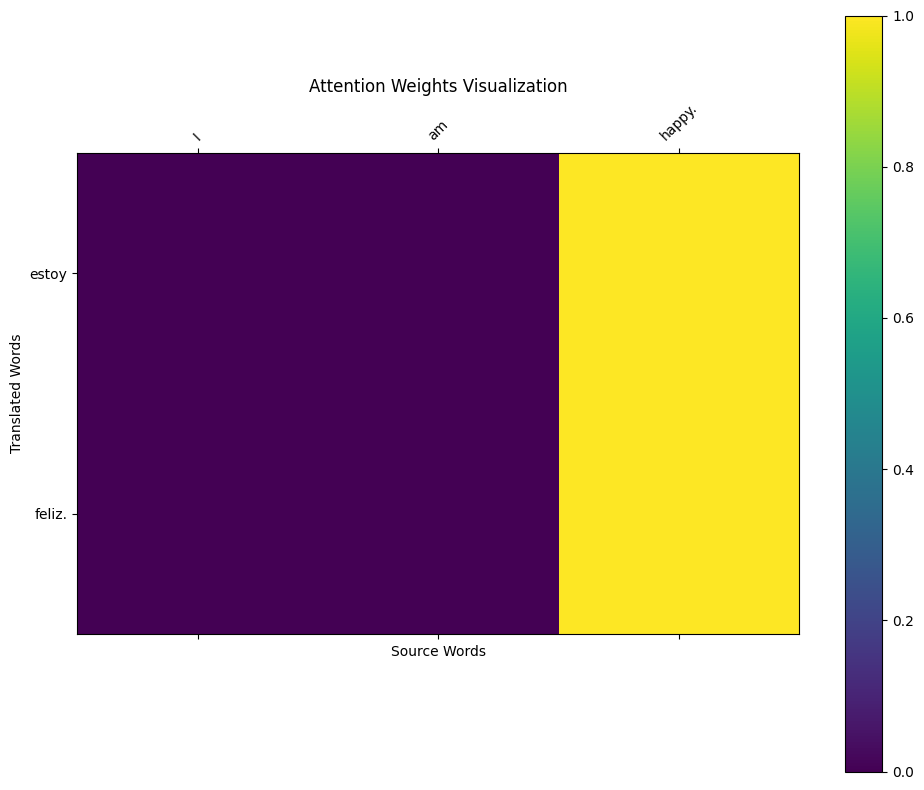

English: How are you?
Spanish: ¿cómo son criaturas

English: Where is the restaurant?
Spanish: ¿dónde está la frazada?

English: Thank you very much.
Spanish: me has muy demasiado.

BLEU Score with Bahdanau Attention: 0.1196

=== Training with Luong Attention ===
Starting training...
Epoch 1/50, Loss: 6.4300, Val Loss: 6.1535
Epoch 2/50, Loss: 5.2456, Val Loss: 5.6032
Epoch 3/50, Loss: 4.3784, Val Loss: 5.2671
Epoch 4/50, Loss: 3.5426, Val Loss: 5.5437
Epoch 5/50, Loss: 2.7746, Val Loss: 5.3726
Epoch 6/50, Loss: 2.2218, Val Loss: 5.4268
Epoch 7/50, Loss: 1.8493, Val Loss: 5.4403
Epoch 8/50, Loss: 1.5858, Val Loss: 5.4073
Epoch 9/50, Loss: 1.3603, Val Loss: 5.4288
Epoch 10/50, Loss: 1.1716, Val Loss: 5.5380
Epoch 11/50, Loss: 1.0055, Val Loss: 5.9037
Epoch 12/50, Loss: 0.8391, Val Loss: 5.7072
Epoch 13/50, Loss: 0.7373, Val Loss: 6.1298
Epoch 14/50, Loss: 0.6255, Val Loss: 5.5867
Epoch 15/50, Loss: 0.5117, Val Loss: 6.3070
Epoch 16/50, Loss: 0.4430, Val Loss: 5.7634
Epoch 17/50, Loss: 0

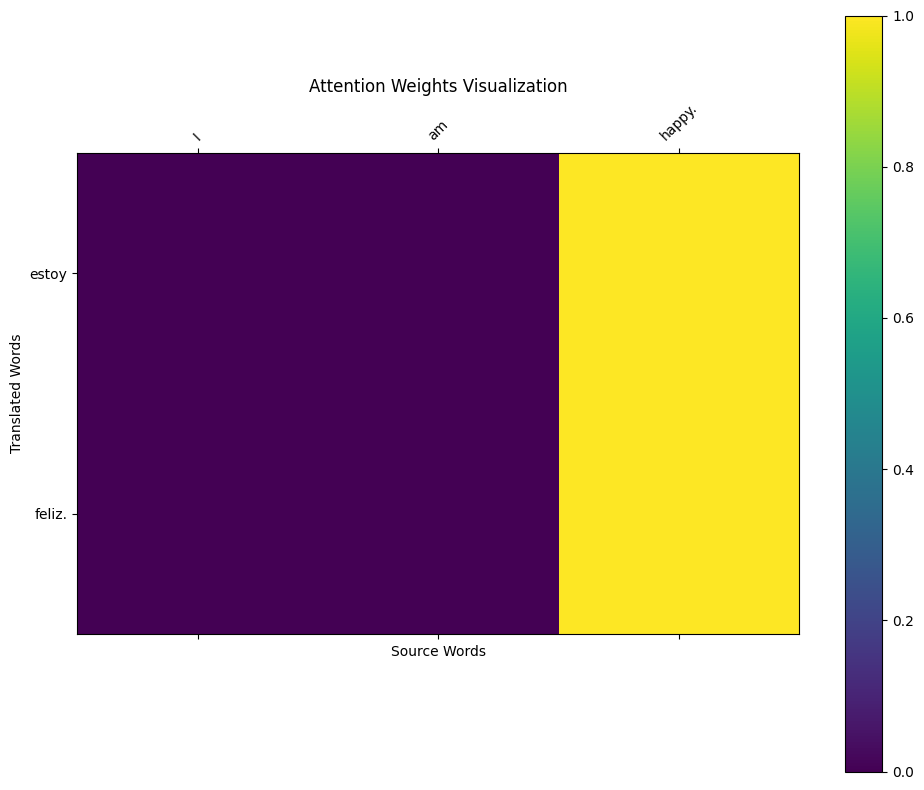

English: How are you?
Spanish: están ¿cómo están usted?

English: Where is the restaurant?
Spanish: ¿adónde está el servicio?

English: Thank you very much.
Spanish: somos muy lista.

BLEU Score with Luong Attention: 0.1309


In [50]:
data_path = "./dataset.txt"  # Update with your path
language_pairs = read_language_pairs(data_path, max_samples=10000)

# Split source and target languages
source_sentences = [pair[0] for pair in language_pairs]
target_sentences = [pair[1] for pair in language_pairs]

# Create dictionaries
source_dict = create_dictionary(source_sentences)
target_dict = create_dictionary(target_sentences)

# Create reverse mappings
index_to_source = {idx: word for word, idx in source_dict.items()}
index_to_target = {idx: word for word, idx in target_dict.items()}

# Prepare data
source_data, target_data = prepare_training_data(language_pairs, source_dict, target_dict)

# Split data
source_train, source_test, target_train, target_test = train_test_split(
    source_data, target_data, test_size=0.1, random_state=SEED)

source_train, source_val, target_train, target_val = train_test_split(
    source_train, target_train, test_size=0.1, random_state=SEED)

# Create models with different attention mechanisms
EMBEDDING_DIM = 256
HIDDEN_DIM = 512

# Try both attention mechanisms
attention_types = ['bahdanau', 'luong']

for attention_type in attention_types:
    print(f"\n=== Training with {attention_type.capitalize()} Attention ===")

    # Initialize model components
    encoder = AttentionEncoder(len(source_dict), EMBEDDING_DIM, HIDDEN_DIM).to(device)
    decoder = AttentionDecoder(len(target_dict), EMBEDDING_DIM, HIDDEN_DIM,
                                attention_type=attention_type).to(device)
    model = AttentionTranslator(encoder, decoder).to(device)

    # Train the model
    train_attention_translator(
        model,
        source_train, target_train,
        val_source=source_val, val_target=target_val,
        epochs=50,
        batch_size=64,
        teacher_forcing=0.5
    )

    # Test translation examples
    test_sentences = [
        "I am happy.",
        "How are you?",
        "Where is the restaurant?",
        "Thank you very much."
    ]

    print("\nTranslation examples:")
    for sentence in test_sentences:
        translation, attention = translate_with_attention(model, sentence)
        print(f"English: {sentence}")
        print(f"Spanish: {translation}")
        print()

        # Visualize attention for the first example
        if sentence == test_sentences[0]:
            visualize_attention_weights(sentence, translation, attention)

    # Calculate BLEU score
    bleu = evaluate_bleu_with_attention(model, source_test, target_test, num_examples=100)
    print(f"BLEU Score with {attention_type.capitalize()} Attention: {bleu:.4f}")